# HOUSE PRICES: ADVANCED REGRESSION TECHNIQUES

This is an introductory notebook which is intended for users getting started with Kaggle Competitions. Here we will apply two different techniques on the Ames house prices dataset, get acquainted with the submission process and finally see if the performance of our predictions improve. 

Developing ensembling models is the focus of this notebook and for that reasons, exploratory data analysis has been kept to the minimum.

The notebook is divided into two sections based on the techniques used for predictions:
    * Using Xgboost
    * Model Averaging 

Each section involves its own preprocessing and model building modules.

## Load the dependencies

In [1]:
import numpy as np # linear algebra
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import xgboost as xgb
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import skew
from sklearn.model_selection import cross_val_score, train_test_split
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LassoCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.ensemble import VotingClassifier,GradientBoostingRegressor

import warnings  
warnings.filterwarnings('ignore')

import os
print(os.listdir("../input"))

['sample_submission.csv', 'test.csv', 'data_description.txt', 'train.csv']


### Load the data

In [2]:
train_data = pd.read_csv('../input/train.csv')
test_data = pd.read_csv('../input/test.csv')
print("Shape of the train data:",train_data.shape)
print("Shape of the test data:",test_data.shape)

Shape of the train data: (1460, 81)
Shape of the test data: (1459, 80)


### Basic EDA

In [3]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
#import pandas_profiling
#report=pandas_profiling.ProfileReport(train_data,check_correlation =True);
#report.to_file(outputfile="eda_report.html")
#report

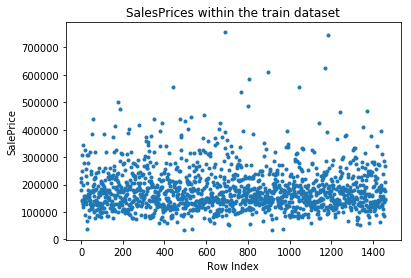

In [5]:
#Check if the dataset is shuffled
plt.figure()
plt.plot(train_data.SalePrice,'.')
plt.title('SalesPrices within the train dataset')
plt.xlabel('Row Index')
plt.ylabel('SalePrice')
plt.show()

<Figure size 432x288 with 0 Axes>

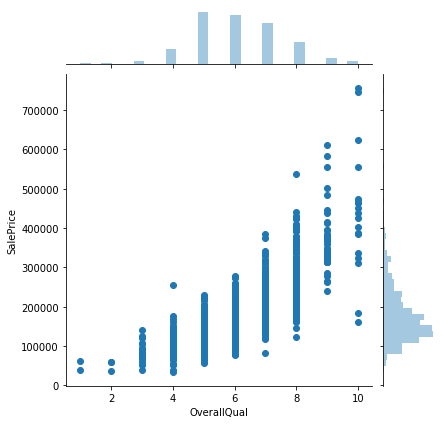

In [6]:
plt.figure()
sns.jointplot(x='OverallQual', y='SalePrice',data= train_data)
plt.show()

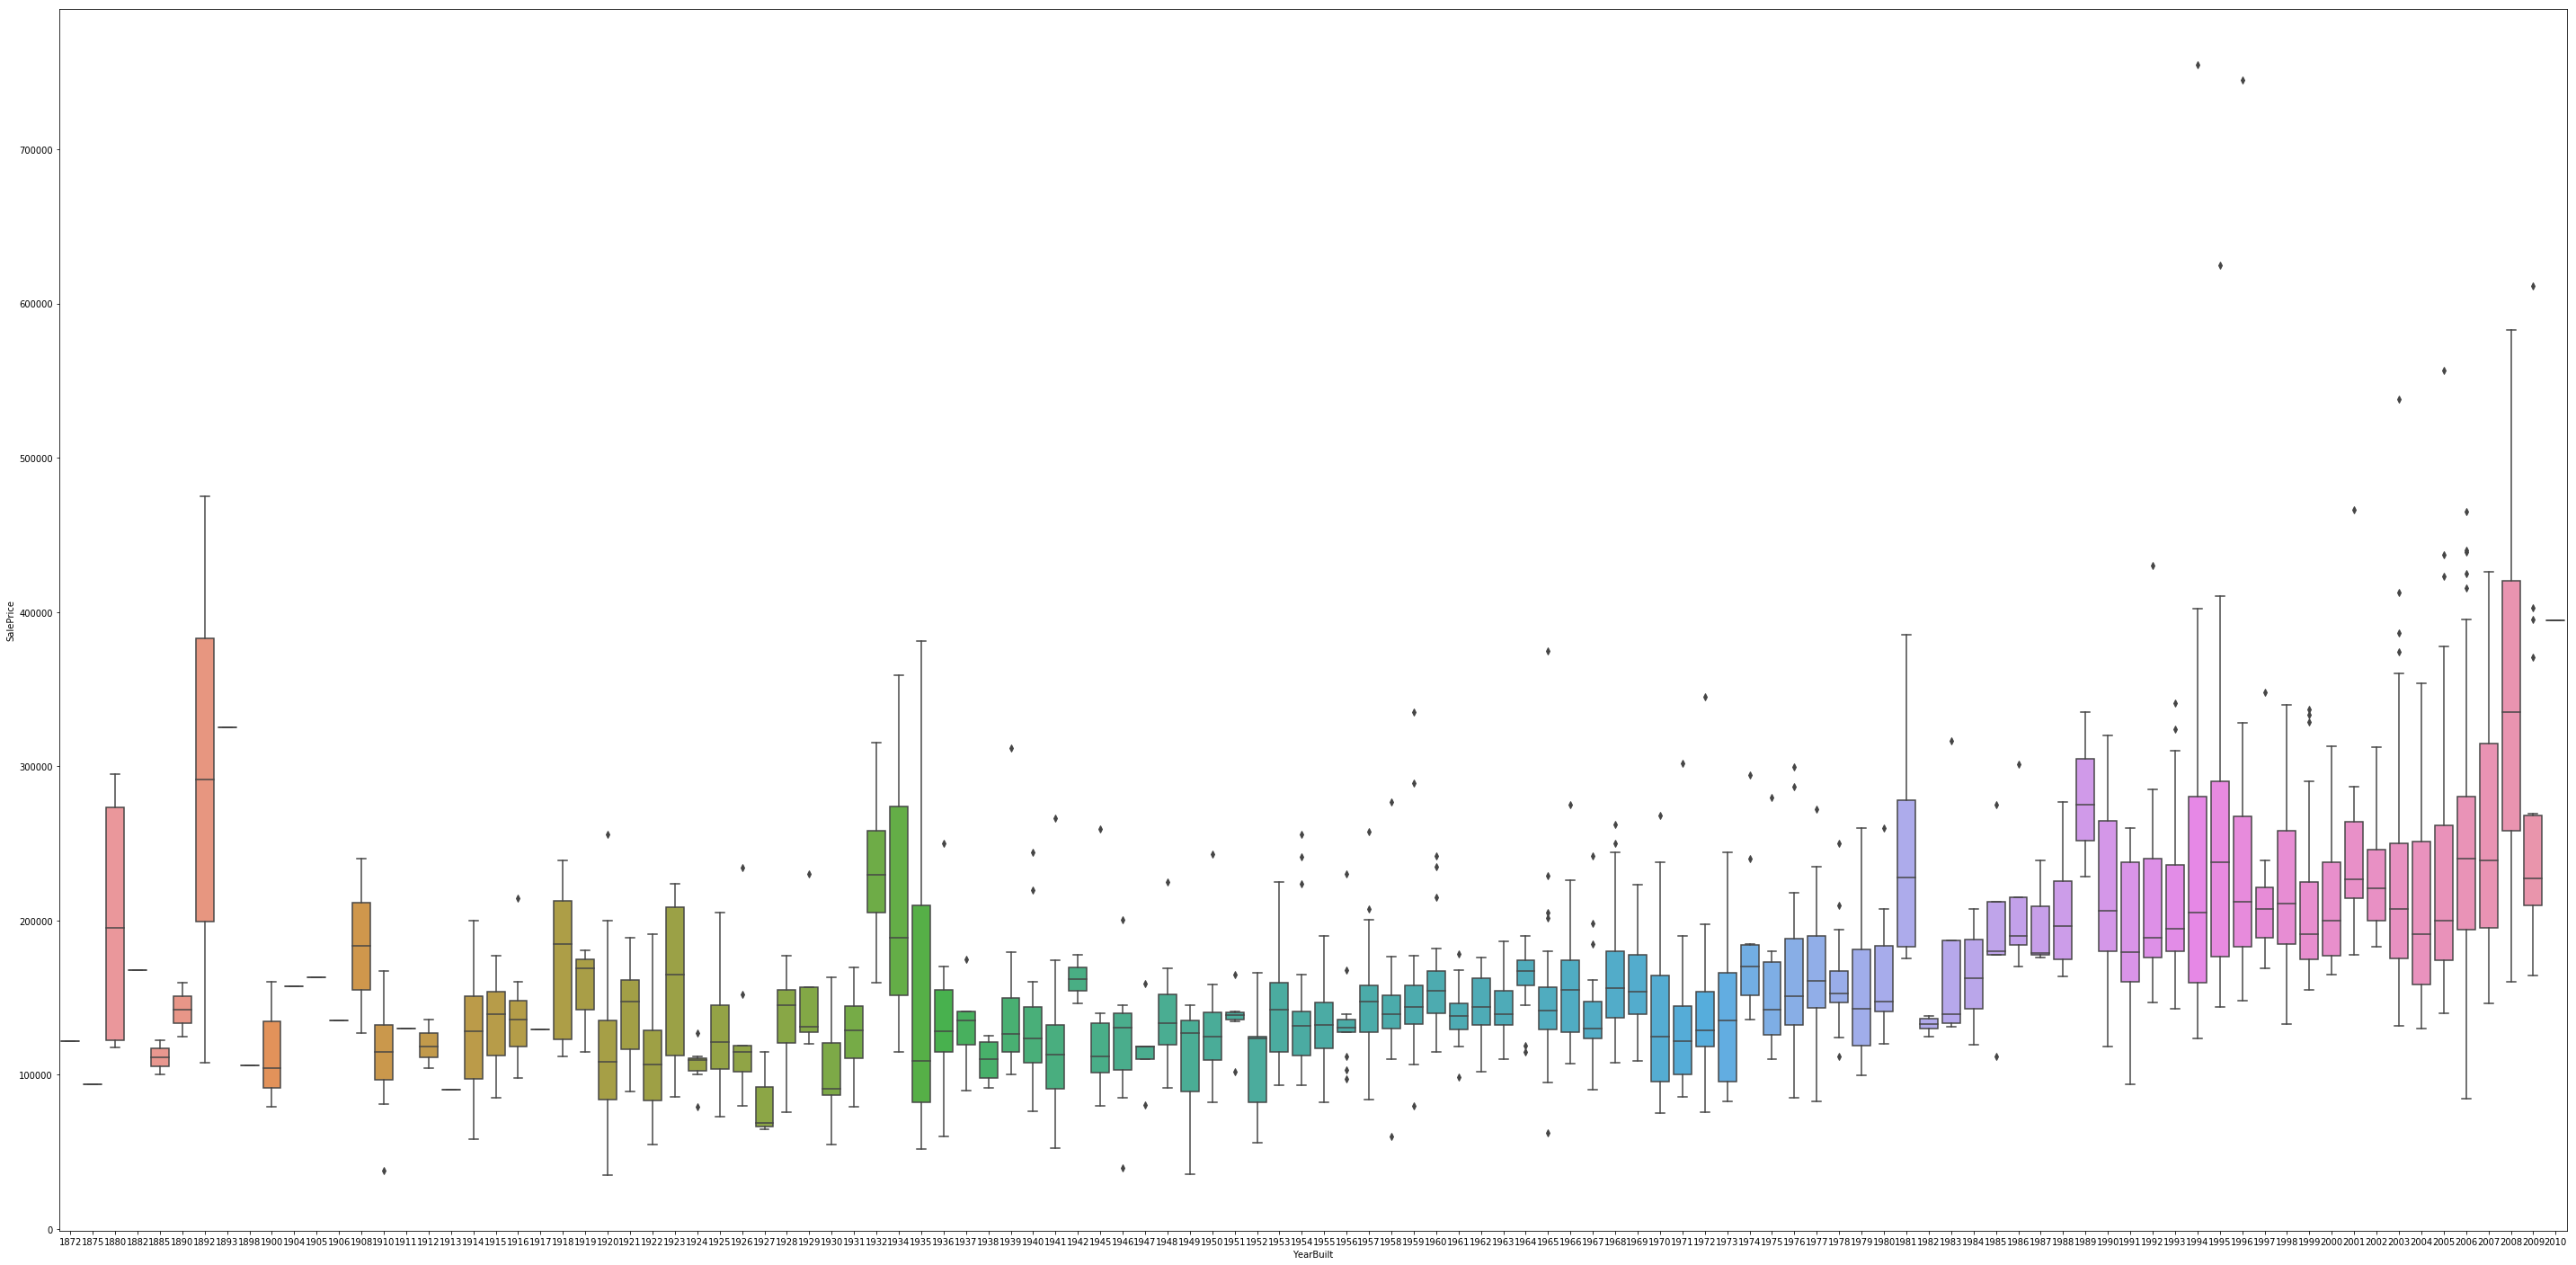

In [7]:
plt.figure(figsize=(50,25))
ax=sns.boxplot(x='YearBuilt',y='SalePrice',data=train_data)
plt.show()

### Preprocessing

#### Imputing missing values

We first concatenate both train and test datasets, then identify the number of features with missing values and finally fill each feature using appropriate method. 

In [8]:
#concatenate both train and test data
test_idx=test_data['Id']
all_data = pd.concat((train_data, test_data), sort=False).reset_index(drop=True)

#"SalePrice" is the target value. We don't include it in data. We don't want "id" affecting our model. Hence remove it.
all_data.drop(['SalePrice'], axis=1, inplace=True)
all_data = all_data.drop(["Id"], axis=1)

In [9]:
all_nans = all_data.isnull().sum()
all_nans = all_nans[all_nans>0]
all_nans.sort_values(ascending=False)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
LotFrontage      486
GarageFinish     159
GarageYrBlt      159
GarageQual       159
GarageCond       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Exterior2nd        1
Exterior1st        1
SaleType           1
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
Electrical         1
KitchenQual        1
GarageCars         1
GarageArea         1
TotalBsmtSF        1
dtype: int64

In [10]:
#Imput missing values

all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data['Utilities'] = all_data['Utilities'].fillna(all_data['Utilities'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

all_data["Electrical"] = all_data["Electrical"].fillna(all_data["Electrical"].mode()[0])
all_data["KitchenQual"] = all_data["KitchenQual"].fillna(all_data["KitchenQual"].mode()[0])
all_data["Functional"] = all_data["Functional"].fillna(all_data["Functional"].mode()[0])
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
for col in ('GarageType','GarageFinish','GarageQual','GarageCond'):
    all_data[col] = all_data[col].fillna("None")
for col in ('GarageYrBlt','GarageCars','GarageArea'):
    all_data[col] = all_data[col].fillna(0)
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["SaleType"] = all_data["SaleType"].fillna(all_data["SaleType"].mode()[0])

#Now check again if there are anymore columns with missing values.
all_nans = all_data.isnull().sum()
all_nans = all_nans[all_nans>0]
all_nans.sort_values(ascending=False)

len(all_nans)

0

Next, we check for normality of numeric features and target variable

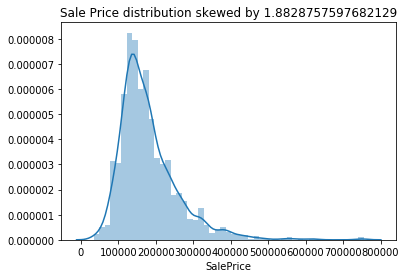

In [11]:
plt.figure()
sns.distplot(train_data['SalePrice'])
plt.title("Sale Price distribution skewed by {}".format(train_data.SalePrice.skew()))
plt.show()

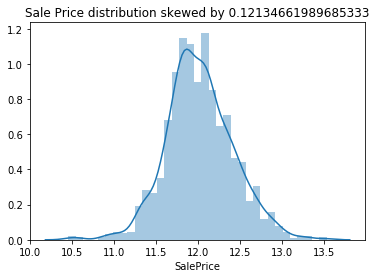

In [12]:
train_data["SalePrice"] = np.log1p(train_data["SalePrice"])
plt.figure()
sns.distplot(train_data['SalePrice'])
plt.title("Sale Price distribution skewed by {}".format(train_data.SalePrice.skew()))
plt.show()

#### Applying log transformation on numerical features

In [13]:
numerical_features = all_data.select_dtypes(exclude = ["object"]).columns
print("Number of numerical features: " + str(len(numerical_features)))

#log transform numerical features
skewness = all_data[numerical_features].apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.7]
skewed_features = skewness.index
all_data[skewed_features] = np.log1p(all_data[skewed_features])

Number of numerical features: 36


#### Encode Categorical features

In [14]:
categorical_features = all_data.select_dtypes(include = ["object"]).columns
print("Number of categorical features:" + str(len(categorical_features)))

#getdummies for categorical features
#Create a dataFrame with dummy categorical values
dummy_all_data = pd.get_dummies(all_data[categorical_features])
#Remove categorical features from original data, which leaves original data with only numerical featues
all_data.drop(categorical_features, axis=1, inplace=True)
#Concatenate the numerical features in original data and categorical features with dummies
all_data = pd.concat([all_data, dummy_all_data], axis=1)
#print(all_data.shape)

Number of categorical features:43


In [15]:
#Separate training and given test data
X = all_data[:train_data.shape[0]]
test_data = all_data[train_data.shape[0]:]
y = train_data["SalePrice"]
print(X.shape)
print(y.shape)

(1460, 302)
(1460,)


# Part 1: Using Xgboost

In [16]:
xgb1 = xgb.XGBRegressor(n_estimators=1000, max_depth=7,min_child_weight=1.5,reg_alpha=0.75,reg_lambda=0.45,learning_rate=0.07,subsample=0.95)
xgb1.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.07, max_delta_step=0, max_depth=7,
       min_child_weight=1.5, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.95)

In [17]:
xgb1_predicted_prices = np.expm1(xgb1.predict(test_data))
print(xgb1_predicted_prices)

[122717.164 161744.16  186043.36  ... 161234.39  115951.99  226139.94 ]


In [18]:
my_submission = pd.DataFrame({'Id': test_idx, 'SalePrice': xgb1_predicted_prices})
my_submission.to_csv('submission1.csv', index=False)

# Part 2: Using Model Averaging

In [19]:
xgb2 = xgb.XGBRegressor(n_estimators=1000, max_depth=3, min_child_weight=1.5,reg_alpha=0.75,reg_lambda=0.45, learning_rate=0.01, subsample=0.95)
xgb2.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1.5, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.95)

In [20]:
params={'n_estimators': 1000,'learning_rate': 0.01,'max_depth': 4}
gbm=GradientBoostingRegressor(**params)
gbm.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [21]:
lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X, y)
lasso_rmse=np.sqrt(-cross_val_score(lasso, X, y, scoring="neg_mean_squared_error", cv = 5)).mean()  
print('Lasso error', lasso_rmse)

Lasso error 0.12302997227760551


In [22]:
#Make predictions on the test data
xgb2_predicted_prices = np.expm1(xgb2.predict(test_data))
gbm_predicted_prices =np.expm1(gbm.predict(test_data))
lasso_predicted_prices = np.expm1(lasso.predict(test_data))
predicted_prices = 0.50 * lasso_predicted_prices+0.25 * gbm_predicted_prices + 0.25 * xgb2_predicted_prices
print(predicted_prices)

[120948.55180689 153501.36635797 181330.27338133 ... 164416.82470327
 117728.72785857 230938.89959461]


In [23]:
#my_submission = pd.DataFrame({'Id': test_idx, 'SalePrice': predicted_prices})
#my_submission.to_csv('submission2.csv', index=False)